###  Task 3: Customer Segmentation Using RFM Analysis


In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# Use correct encoding for CSV with special characters
df = pd.read_csv(
    r'D:\Elevvo Internship tasks\Level 1\Task 3\OnlineRetail.csv',
    encoding='ISO-8859-1'
)

# Preview first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### Clean the Data

In [3]:
# Remove missing Customer IDs
df = df.dropna(subset=['CustomerID'])

# Remove canceled orders (Quantity < 0)
df = df[df['Quantity'] > 0]

# Compute total price per transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


##### Compute RFM Metrics

In [4]:
# Make sure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Define reference date (the day after the last purchase)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Compute TotalPrice if not already created
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Compute RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  
    'InvoiceNo': 'nunique',                                    
    'TotalPrice': 'sum'                                        
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [5]:
# Rank customers into 5 groups (1=low, 5=high)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine into a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [6]:
# Convert R, F, M scores to integers
rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

# Define segmentation function
def segment_customer(row):
    if row["R_Score"] == 5 and row["F_Score"] >= 4:
        return "Champions"
    elif row["R_Score"] >= 4 and row["F_Score"] >= 3:
        return "Loyal Customers"
    elif row["R_Score"] >= 3 and row["F_Score"] <= 2:
        return "At Risk"
    else:
        return "Others"

# Apply segmentation
rfm["Segment"] = rfm.apply(segment_customer, axis=1)

# Preview
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Others
1,12347.0,2,7,4310.00,5,5,5,555,Champions
2,12348.0,75,4,1797.24,2,4,4,244,Others
3,12349.0,19,1,1757.55,4,1,4,414,At Risk
4,12350.0,310,1,334.40,1,1,2,112,Others


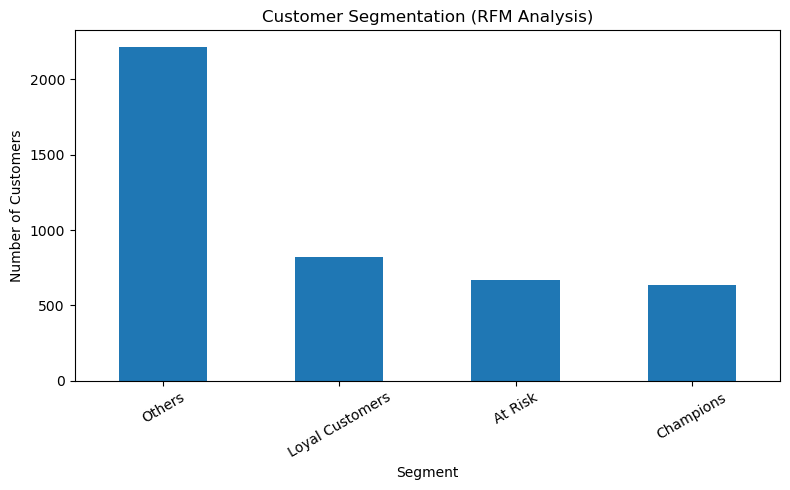

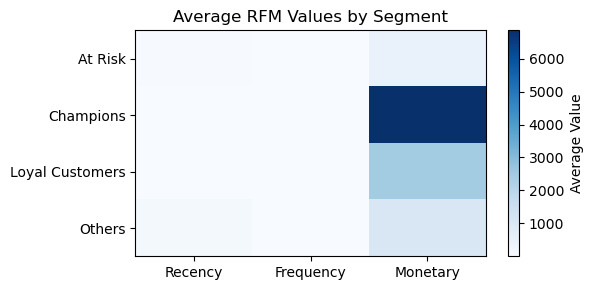

In [7]:
# Bar chart of customer segments
plt.figure(figsize=(8, 5))
rfm['Segment'].value_counts().plot(kind='bar')
plt.title('Customer Segmentation (RFM Analysis)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Heatmap of average RFM values by segment
rfm_group = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()

plt.figure(figsize=(6, 3))
plt.imshow(rfm_group, cmap='Blues', aspect='auto')
plt.colorbar(label='Average Value')
plt.xticks(ticks=range(len(rfm_group.columns)), labels=rfm_group.columns)
plt.yticks(ticks=range(len(rfm_group.index)), labels=rfm_group.index)
plt.title('Average RFM Values by Segment')
plt.tight_layout()
plt.show()


The first graph, titled “Customer Segmentation (RFM Analysis)”, is a bar chart that shows how customers are divided into four main groups: Others, Loyal Customers, At Risk, and Champions. The tallest bar belongs to the Others group, meaning most customers fall into this category. These customers buy less often and spend less money. Loyal Customers appear next and represent people who make regular purchases, showing a stable relationship with the business. The At Risk group includes customers who used to buy before but have not purchased recently, suggesting they may need reminders or offers to come back. The Champions group, though smaller, is very important because they buy frequently and spend the most.

The second graph, titled “Average RFM Values by Segment”, is a heatmap that shows the average values of Recency, Frequency, and Monetary for each group. The darker the color, the higher the value. The Champions row has the darkest shades for Frequency and Monetary, showing that they shop more often and spend the most. Loyal Customers also have good values but not as high as Champions. On the other hand, Others and At Risk have lighter colors, which means they buy less often, spend less, and may not have bought recently. This heatmap helps the business quickly see which groups are most active and valuable, guiding where to focus marketing and engagement efforts.